### Install dependencies

We'll be using:

* keras for building the ANN
* numpy for array handling
* sklearn for converting labels to one-hot vectors

### Imports

Apart from the libraries listed above we'll be using

* `typing` for static typing

In [14]:
!pip install keras numpy sklearn > /dev/null 2>&1

import keras.utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import numpy
from sklearn.preprocessing import LabelEncoder
from typing import List

### Loading the data

TODO

In [15]:
class Loader:
  DATA_PATH = 'data/'

  def labels_to_numbers(labels: List[str]) -> List[int]:
    """
    Transforms:
      ['Ghoul', 'Goblin', 'Ghoul', 'Ghoul', 'Ghost',
    to:
      [1, 2, 1, 1, 0,
    """
    return LabelEncoder().fit(labels).transform(labels)
    
  def load_features(file_name: str) -> List:
    """
    Loads the features we are using for inferring the target.
    Those features are: bone_length  rotting_flesh  hair_length  has_soul color

    The csv files look like this:

    id  bone_length  rotting_flesh  hair_length  has_soul  color    type
    0     0.354512       0.350839     0.465761  0.781142  clear   Ghoul
    1     0.575560       0.425868     0.531401  0.439899  green  Goblin
    2     0.467875       0.354330     0.811616  0.791225  black   Ghoul
    """
    path = Loader.DATA_PATH + file_name
    numeric_features = numpy.genfromtxt(path,
                                        skip_header=1,
                                        delimiter=",",
                                        usecols=(1, 2, 3, 4))
    colors = numpy.genfromtxt(path,
                              skip_header=1,
                              delimiter=",",
                              usecols=5,
                              dtype=str)
    accumulator = []
    for row, color_as_number in zip(numeric_features, Loader.labels_to_numbers(colors)):
      accumulator.extend([numpy.append(row, color_as_number)])
    return numpy.asarray(accumulator)
  
  def load_targets(file_name: str) -> List:
    """
    Loads the labels we are using for inferring the target ('Ghost', 'Goblin', 'Ghoul')
    and transforms them into a one-hot vector.
    So basically this:
      ['Ghoul', 'Goblin', 'Ghoul', 'Ghoul', 'Ghost', .....
    becomes:
      [[ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  0.],
    """
    labels = numpy.genfromtxt(Loader.DATA_PATH + file_name,
                              skip_header=1,
                              delimiter=",",
                              usecols=6,
                              dtype=str)
    return keras.utils.to_categorical(Loader.labels_to_numbers(labels))

### Creating the training and the test sets

We have 371 records for training but no test data.
So let's just use the first 350 records for training and the last 21 for testing

In [16]:
SLICE_AT = 350

features = Loader.load_features('train.csv')
targets = Loader.load_targets('train.csv')
x_train = features[0:SLICE_AT]
y_train = targets[0:SLICE_AT]
x_test = features[SLICE_AT:]
y_test = targets[SLICE_AT:]
x_for_prediction = Loader.load_features('test.csv')

### Configurations for the ANN

Let's generate all possible combinations we want to try out.
We'll take the following 3 hyper parameters into account:

* number of hidden layers
* what optimizers to use
* the [dropout](https://en.wikipedia.org/wiki/Dropout_(neural_networks))

In [17]:
# TODO mypy annotations missing
def all_configurations(optimizers: List = ['sgd'], max_layers: int = 3, max_dropout: float = 0.3):
  """
  :return
    [{'layers': 0, 'dropout': 0.0, 'optimizer': 'sgd'},
     {'layers': 1, 'dropout': 0.0, 'optimizer': 'sgd'},
     {'layers': 2, 'dropout': 0.0, 'optimizer': 'sgd'},
     {'layers': 0, 'dropout': 0.1, 'optimizer': 'sgd'}
  """
  configurations = []
  for optimizer in optimizers:
      for dropout in numpy.arange(0, max_dropout, 0.1):
          for layers in range(max_layers):
              configurations.append({'optimizer' : optimizer,
                                     'dropout': round(dropout, 1),
                                     'layers' : layers})
  return configurations

[{'layers': 0, 'dropout': 0.0, 'optimizer': 'sgd'}, {'layers': 1, 'dropout': 0.0, 'optimizer': 'sgd'}, {'layers': 2, 'dropout': 0.0, 'optimizer': 'sgd'}, {'layers': 0, 'dropout': 0.10000000000000001, 'optimizer': 'sgd'}, {'layers': 1, 'dropout': 0.10000000000000001, 'optimizer': 'sgd'}, {'layers': 2, 'dropout': 0.10000000000000001, 'optimizer': 'sgd'}, {'layers': 0, 'dropout': 0.20000000000000001, 'optimizer': 'sgd'}, {'layers': 1, 'dropout': 0.20000000000000001, 'optimizer': 'sgd'}, {'layers': 2, 'dropout': 0.20000000000000001, 'optimizer': 'sgd'}]


### Building the models

* The dimension of features is the input dimension for the input neurons
* The dimension of the output is the number of output neurons

A lot of inspiration for the set up below is coming from keras's [sequential model guide](https://keras.io/getting-started/sequential-model-guide/) (see the section: "Multilayer Perceptron (MLP) for multi-class softmax classification")

In [17]:
FEATURES = ['bone_length', 'rotting_flesh', 'hair_length', 'has_soul', 'color']
INPUT_DIM = len(FEATURES)
VALID_TYPES = ['Ghost', 'Goblin', 'Ghoul']
OUTPUT_DIM = len(VALID_TYPES)
MAX_LAYERS = 5
MAX_DROPOUT = 0.5
NEURONS_PER_LAYER = 10

OPTIMIZERS = ['sgd', 'rmsprop', 'adagrad']

scores = []

import itertools

print("Generating, training and evaluating all possible model configurations...")

for configuration in all_configurations(optimizers = OPTIMIZERS, max_dropout = MAX_DROPOUT, max_layers = MAX_LAYERS):
  model = Sequential()
  model.add(Dense(NEURONS_PER_LAYER, activation='relu', input_dim=INPUT_DIM))

  for _ in itertools.repeat(None, configuration['layers']):
    model.add(Dropout(configuration['dropout']))
    model.add(Dense(NEURONS_PER_LAYER, activation='relu'))

  model.add(Dense(OUTPUT_DIM, activation='softmax'))

  model.compile(loss = 'categorical_crossentropy',
                optimizer = configuration['optimizer'],
                metrics = ['accuracy'])

  model.fit(x_train, y_train, verbose=0, epochs=20, batch_size=128)
  score = model.evaluate(x_test, y_test, verbose=0, batch_size=128)
  scores.append({'score' : score, 'configuration' : configuration})
  
print("Model evaluation finished!")

Generating, training and evaluating all possible model configurations...


KeyboardInterrupt: 

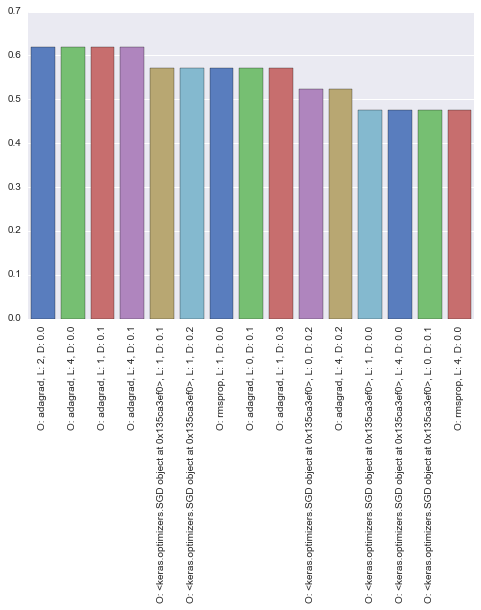

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

scores_by_accuracy = sorted(scores, reverse=True, key=lambda k: k['score'][1])

descriptions = []
accuracies = []

for element in scores_by_accuracy[:15]:
  configuration = element['configuration']
  description = "O: {}, L: {}, D: {}".format(configuration['optimizer'], configuration['layers'], configuration['dropout'])
  descriptions.append(description)
  accuracies.append(element['score'][1])

bar_plot = sns.barplot(x=descriptions,y=accuracies,
                        palette="muted")
plt.xticks(rotation=90)
plt.show()